In [1]:
%matplotlib inline
import pickle
import subprocess
import tempfile

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import numpy as np


plt.rcParams['figure.figsize'] = (7, 3.5)

In [2]:
def run_ngspice(script):
    with tempfile.NamedTemporaryFile('w', delete_on_close=False) as f:
        f.write(script)
        f.close()
        subprocess.run([
            '/bin/bash', '-c',
            f'cd ../; source setup-pdk; cd - > /dev/null; ngspice {f.name} > /dev/null 2>&1'
        ], check=True)

def read_spice_output(f):
    signals = ['C', 'R', 'D', 'nand0', 'nand1', 'nand2', 'nand3', 'Q', 'nand5']
    data = np.fromfile(f, sep=' ').reshape(-1, 2 * len(signals))
    t = {s: data[:, 2*j] for j, s in enumerate(signals)}
    x = {s: data[:, 2*j+1] for j, s in enumerate(signals)}
    return {'t': t, 'x': x}

def run_sim(template, **kwargs):
    with tempfile.NamedTemporaryFile('w', delete_on_close=False) as f_out:
        f_out.close()  # ngspice will write to this file
        run_ngspice(template.format(output_file=f_out.name, **kwargs))
        return read_spice_output(f_out.name)

In [3]:
vdd = 1.2

def vdd_model():
    return np.random.uniform(vdd - 0.05, vdd + 0.05)

clock_period = 1e-9

temperature = 27

def temperature_model():
    return np.random.uniform(-10, 100)

In [4]:
output_delay_template = """
.temp {temperature}
.lib cornerMOSlv.lib {mos_corner}
.include ../magic/fdc_dense.spice

Vdd VDD GND {vdd}
Vss VSS GND 0
.param rise_time=0p
.param clock_period=1n
Vresetn R GND PULSE({vdd} 0 0p 0 rise_time {{0.5 * clock_period}} 0)
Vdata D GND PULSE(0 {vdd} {{0.5 * clock_period}} rise_time rise_time clock_period 0)
Vclk C GND PULSE(0 {vdd} clock_period rise_time rise_time {{0.5 * clock_period}} clock_period)

.tran 1p {{3 * clock_period}}

.control
run
wrdata {output_file} C R D nand0 nand1 nand2 nand3 Q nand5
quit
.endc

.end
"""

In [5]:
def load_data(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

def save_data(path, data):
    with open(path, 'wb') as f:
        pickle.dump(data, f)

In [6]:
corners = ['mos_tt_stat', 'mos_ff', 'mos_ss', 'mos_sf', 'mos_fs', 'mos_tt']
runs_per_corner = {'mos_tt_stat': 100}

try:
    data_output_delay = load_data('output_delay.pickle')
except FileNotFoundError:
    data_output_delay = {}
    for corner in corners:
        def sim(vdd=vdd, temperature=temperature):
            return run_sim(output_delay_template, mos_corner=corner, vdd=vdd, temperature=temperature) | {'vdd': vdd}
    
        if corner in runs_per_corner:
            for run in range(runs_per_corner[corner]):
                data_output_delay[f'{corner}_{run:04}'] = sim(vdd=vdd_model(), temperature=temperature_model())
        else:
            data_output_delay[corner] = sim()
    save_data('output_delay.pickle', data_output_delay)

In [7]:
def corner_color(corner):
    if corner == 'mos_ff':
        return 'red'
    if corner == 'mos_ss':
        return 'blue'
    if corner == 'mos_tt':
        return 'green'
    if corner in ['mos_sf', 'mos_fs']:
        return 'black'
    else:
        return 'grey'

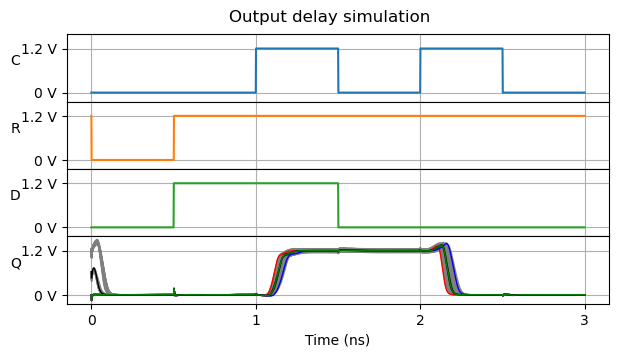

In [8]:
fig, axs = plt.subplots(4, 1, sharex=True, sharey=True)
c0 = 'mos_tt'
data = data_output_delay
for j, sig in enumerate(['C', 'R', 'D']):
    axs[j].plot(data[c0]['t'][sig] * 1e9, data[c0]['x'][sig], color=f'C{j}')
    axs[j].set_ylabel(sig, rotation=0)
for corner in data:
    axs[-1].plot(data[corner]['t']['Q'] * 1e9, data[corner]['x']['Q'],
                 color=corner_color(corner), linewidth=1)
axs[-1].set_ylabel('Q', rotation=0)
for ax in axs:
    ax.grid()
    ax.set_yticks([0, 1.2], ['0 V', '1.2 V'])
    ax.xaxis.set_major_locator(plticker.MultipleLocator(base=1))
axs[-1].set_xlabel('Time (ns)')    
plt.subplots_adjust(hspace=0)
plt.suptitle('Output delay simulation', y=0.95);

In [9]:
def output_delay(traces):
    vdd = traces['vdd']
    threshold_crosses = traces['t']['Q'][np.where(np.diff(traces['x']['Q'] > 0.7 * vdd))[0]]
    delay_01_slow = (
        np.max(threshold_crosses[(clock_period < threshold_crosses)
            & (threshold_crosses < 2 * clock_period)])
        - clock_period)
    threshold_crosses = traces['t']['Q'][np.where(np.diff(traces['x']['Q'] >= 0.3 * vdd))[0]]
    delay_01_fast = (
        np.min(threshold_crosses[(clock_period < threshold_crosses)
            & (threshold_crosses < 2 * clock_period)])
        - clock_period)
    threshold_crosses = traces['t']['Q'][np.where(np.diff(traces['x']['Q'] < 0.3 * vdd))[0]]
    delay_10_slow = (
        np.max(threshold_crosses[(2 * clock_period < threshold_crosses)
            & (threshold_crosses < 3 * clock_period)])
        - 2 * clock_period)
    threshold_crosses = traces['t']['Q'][np.where(np.diff(traces['x']['Q'] <= 0.7 * vdd))[0]]
    delay_10_fast = (
        np.min(threshold_crosses[(2 * clock_period < threshold_crosses)
            & (threshold_crosses < 3 * clock_period)])
        - 2 * clock_period)
    return {'01_fast': delay_01_fast, '01_slow': delay_01_slow,
            '10_fast': delay_10_fast, '10_slow': delay_10_slow,
            'fast': min(delay_01_fast, delay_10_fast),
            'slow': max(delay_01_slow, delay_10_slow),
           }

In [10]:
output_delay_fast = min(output_delay(v)['fast'] for v in data.values())
output_delay_slow = max(output_delay(v)['slow'] for v in data.values())
print(f'Measured output delay\nfast corner: {output_delay_fast*1e12:.1f} ps\n'
      f'slow corner: {output_delay_slow*1e12:.1f} ps')

Measured output delay
fast corner: 101.2 ps
slow corner: 229.2 ps


In [11]:
data_change_template = """
.temp {temperature}
.lib cornerMOSlv.lib {mos_corner}
.include ../magic/fdc_dense.spice

Vdd VDD GND {vdd}
Vss VSS GND 0
.param rise_time=0p
.param clock_period=1n
Vresetn R GND {vdd}
Vdata D GND PULSE({data0} {data1} {{2 * clock_period + {data_change}}} 0 0 0)
Vclk C GND PULSE(0 {vdd} clock_period rise_time rise_time {{0.5 * clock_period}} clock_period)

.tran 1p {{3 * clock_period}}

.control
run
wrdata {output_file} C R D nand0 nand1 nand2 nand3 Q nand5
quit
.endc

.end
"""

In [12]:
setups = np.arange(-100e-12, -10e-12, 1e-12)
try:
    data_setup = load_data('setup.pickle')
except FileNotFoundError:
    data_setup = []
    for n, setup in enumerate(setups):
        data_setup.append(run_sim(data_change_template, mos_corner='mos_ss',
                          vdd=vdd, temperature=temperature,
                          data0=0, data1=vdd, data_change=setup))
    save_data('setup.pickle', data_setup)

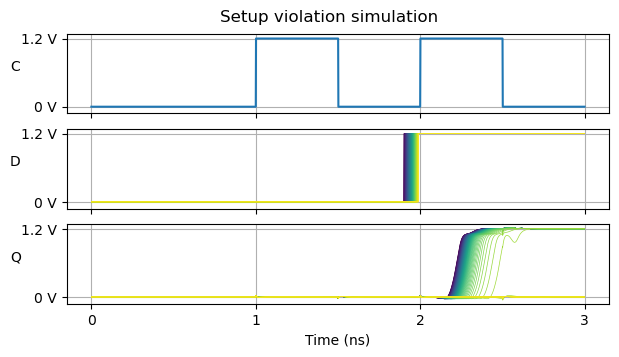

In [13]:
data = data_setup
fig, axs = plt.subplots(3, 1, sharex=True, sharey=True)
axs[0].plot(data[0]['t']['C'] * 1e9, data[0]['x']['C'])
axs[0].set_ylabel('C', rotation=0)
axs[1].set_ylabel('D', rotation=0)
axs[2].set_ylabel('Q', rotation=0)
for n, d in enumerate(data):
    axs[1].plot(d['t']['D'] * 1e9, d['x']['D'],
                color=matplotlib.colormaps['viridis'](float(n / len(data))), linewidth=0.5)
    axs[2].plot(d['t']['Q'] * 1e9, d['x']['Q'],
                color=matplotlib.colormaps['viridis'](float(n / len(data))), linewidth=0.5)
for ax in axs:
    ax.grid()
    ax.set_yticks([0, 1.2], ['0 V', '1.2 V'])
    ax.xaxis.set_major_locator(plticker.MultipleLocator(base=1))
axs[-1].set_xlabel('Time (ns)')
plt.suptitle('Setup violation simulation', y=0.95);

In [14]:
corners = ['mos_ss_mismatch']
runs_per_corner = {'mos_ss_mismatch': 50}
setups = np.arange(-110e-12, -39e-12, 1e-12)
try:
    data_setup2 = load_data('setup2.pickle')
except FileNotFoundError:
    data_setup2 = [{} for _ in range(setups.size)]
    for n, setup in enumerate(setups):
        for corner in corners:
            def sim(vdd=vdd, temperature=temperature, rising_edge=True):
                if rising_edge:
                    data0 = 0
                    data1 = vdd
                else:
                    data0 = vdd
                    data1 = 0
                return run_sim(data_change_template, mos_corner=corner,
                               vdd=vdd, temperature=temperature,
                               data0=data0, data1=data1,
                               data_change=setup) | {'vdd': vdd, 'rising_edge': rising_edge}
    
            if corner in runs_per_corner:
                for run in range(runs_per_corner[corner]):
                    for rising_edge in [True, False]:
                        data_setup2[n][f'{corner}_{run:04}_{int(rising_edge)}'] = sim(
                            vdd=vdd_model(), temperature=temperature_model(), rising_edge=rising_edge)
            else:
                for rising_edge in [True, False]:
                    data_setup2[n][f'{corner}_{int(rising_edge)}'] = sim(rising_edge=rising_edge)
    save_data('setup2.pickle', data_setup2)

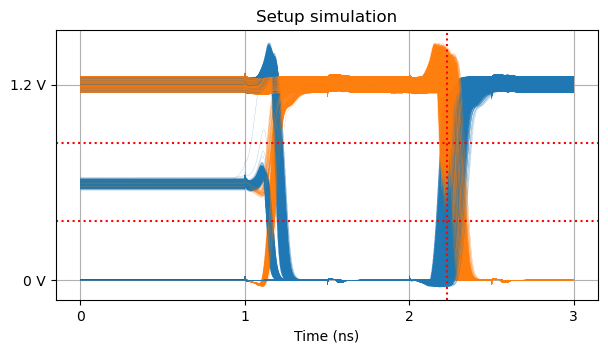

In [15]:
data = data_setup2
for d in data:
    for corner in d:
        plt.plot(d[corner]['t']['Q'] * 1e9, d[corner]['x']['Q'],
                 color='C0' if d[corner]['rising_edge'] else 'C1', linewidth=0.1)
plt.axvline(x=(2 * clock_period + output_delay_slow) * 1e9, linestyle=':', color='red')
plt.axhline(y=0.7 * vdd, linestyle=':', color='red')
plt.axhline(y=0.3 * vdd, linestyle=':', color='red')
plt.grid()
plt.yticks([0, 1.2], ['0 V', '1.2 V'])
plt.gca().xaxis.set_major_locator(plticker.MultipleLocator(base=1))
plt.xlabel('Time (ns)')
plt.title('Setup simulation');

In [16]:
def setup_cost(traces, setup):
    # this is defined as output delay that needs to be defined for this
    # setup time, minus this setup time
    vdd = traces['vdd']
    if traces['rising_edge']:
        threshold_crosses = traces['t']['Q'][np.where(np.diff(traces['x']['Q'] > 0.7 * vdd))[0]]
    else:
        threshold_crosses = traces['t']['Q'][np.where(np.diff(traces['x']['Q'] < 0.3 * vdd))[0]]
    output_delay = np.max(threshold_crosses[(2 * clock_period < threshold_crosses)]) - 2 * clock_period
    return output_delay - setup

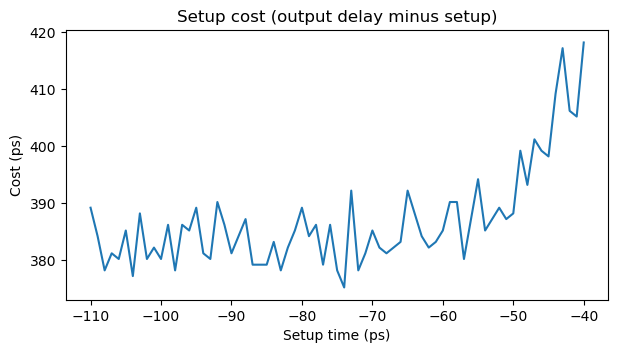

In [17]:
setup_costs = np.array([max(setup_cost(v, setup) for v in d.values()) for setup, d in zip(setups, data)])
plt.plot(setups * 1e12, setup_costs * 1e12)
plt.title('Setup cost (output delay minus setup)')
plt.xlabel('Setup time (ps)')
plt.ylabel('Cost (ps)');

In [18]:
data_change2_template = """
.temp {temperature}
.lib cornerMOSlv.lib {mos_corner}
.include ../magic/fdc_dense.spice

Vdd VDD GND {vdd}
Vss VSS GND 0
.param rise_time=0p
.param clock_period=1n
Vresetn R GND {vdd}
Vdata D GND PULSE({data1} {data0} {{1.5 * clock_period}} 0 0 {{0.5 * clock_period + {data_change}}} 0)
Vclk C GND PULSE(0 {vdd} clock_period rise_time rise_time {{0.5 * clock_period}} clock_period)

.tran 1p {{3 * clock_period}}

.control
run
wrdata {output_file} C R D nand0 nand1 nand2 nand3 Q nand5
quit
.endc

.end
"""

In [19]:
holds = np.arange(-25e-12, -14e-12, 1e-12)
try:
    data_hold = load_data('hold.pickle')
except FileNotFoundError:
    data_hold = []
    for n, hold in enumerate(holds):
        data_hold.append(run_sim(data_change_template, mos_corner='mos_ff',
                            vdd=vdd, temperature=temperature,
                            data0=0, data1=vdd, data_change=hold))
    save_data('hold.pickle', data_hold)

try:
    data_hold2 = load_data('hold2.pickle')
except FileNotFoundError:
    data_hold2 = []
    for n, hold in enumerate(holds):
        data_hold2.append(run_sim(data_change2_template, mos_corner='mos_ff',
                            vdd=vdd, temperature=temperature,
                            data0=0, data1=vdd, data_change=hold))
    save_data('hold2.pickle', data_hold2)

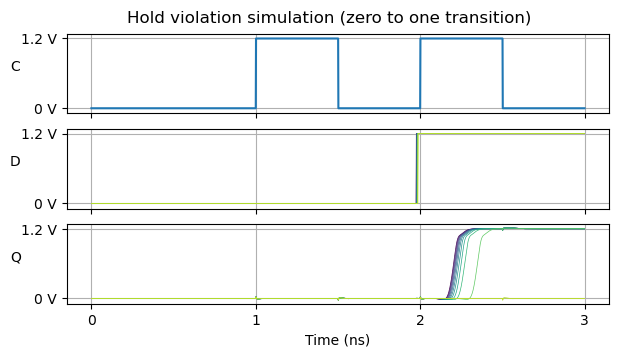

In [20]:
data = data_hold
fig, axs = plt.subplots(3, 1, sharex=True, sharey=True)
axs[0].plot(data[0]['t']['C'] * 1e9, data[0]['x']['C'])
axs[0].set_ylabel('C', rotation=0)
axs[1].set_ylabel('D', rotation=0)
axs[2].set_ylabel('Q', rotation=0)
for n, d in enumerate(data):
    axs[1].plot(d['t']['D'] * 1e9, d['x']['D'],
                color=matplotlib.colormaps['viridis'](float(n / len(data))), linewidth=0.5)
    axs[2].plot(d['t']['Q'] * 1e9, d['x']['Q'],
                color=matplotlib.colormaps['viridis'](float(n / len(data))), linewidth=0.5)
for ax in axs:
    ax.grid()
    ax.set_yticks([0, 1.2], ['0 V', '1.2 V'])
    ax.xaxis.set_major_locator(plticker.MultipleLocator(base=1))
axs[-1].set_xlabel('Time (ns)')
plt.suptitle('Hold violation simulation (zero to one transition)', y=0.95);

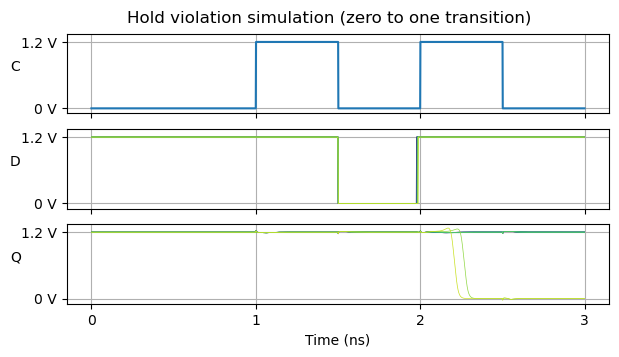

In [21]:
data = data_hold2
fig, axs = plt.subplots(3, 1, sharex=True, sharey=True)
axs[0].plot(data[0]['t']['C'] * 1e9, data[0]['x']['C'])
axs[0].set_ylabel('C', rotation=0)
axs[1].set_ylabel('D', rotation=0)
axs[2].set_ylabel('Q', rotation=0)
for n, d in enumerate(data):
    axs[1].plot(d['t']['D'] * 1e9, d['x']['D'],
                color=matplotlib.colormaps['viridis'](float(n / len(data))), linewidth=0.5)
    axs[2].plot(d['t']['Q'] * 1e9, d['x']['Q'],
                color=matplotlib.colormaps['viridis'](float(n / len(data))), linewidth=0.5)
for ax in axs:
    ax.grid()
    ax.set_yticks([0, 1.2], ['0 V', '1.2 V'])
    ax.xaxis.set_major_locator(plticker.MultipleLocator(base=1))
axs[-1].set_xlabel('Time (ns)')
plt.suptitle('Hold violation simulation (zero to one transition)', y=0.95);

In [22]:
holds = np.arange(-5e-12, 6e-12, 1e-12)
try:
    data_hold3 = load_data('hold3.pickle')
except FileNotFoundError:
    data_hold3 = []
    for n, hold in enumerate(holds):
        data_hold3.append(run_sim(data_change_template, mos_corner='mos_ff',
                                  vdd=vdd, temperature=temperature,
                                  data0=vdd, data1=0, data_change=hold))
    save_data('hold3.pickle', data_hold3)

try:
    data_hold4 = load_data('hold4.pickle')
except FileNotFoundError:
    data_hold4 = []
    for n, hold in enumerate(holds):
        data_hold4.append(run_sim(data_change2_template, mos_corner='mos_ff',
                                  vdd=vdd, temperature=temperature,
                                  data0=vdd, data1=0, data_change=hold))
    save_data('hold4.pickle', data_hold4)

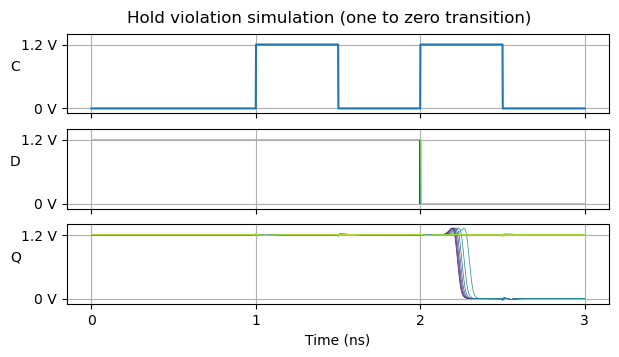

In [23]:
data = data_hold3
fig, axs = plt.subplots(3, 1, sharex=True, sharey=True)
axs[0].plot(data[0]['t']['C'] * 1e9, data[0]['x']['C'])
axs[0].set_ylabel('C', rotation=0)
axs[1].set_ylabel('D', rotation=0)
axs[2].set_ylabel('Q', rotation=0)
for n, d in enumerate(data):
    axs[1].plot(d['t']['D'] * 1e9, d['x']['D'],
                color=matplotlib.colormaps['viridis'](float(n / len(data))), linewidth=0.5)
    axs[2].plot(d['t']['Q'] * 1e9, d['x']['Q'],
                color=matplotlib.colormaps['viridis'](float(n / len(data))), linewidth=0.5)
for ax in axs:
    ax.grid()
    ax.set_yticks([0, 1.2], ['0 V', '1.2 V'])
    ax.xaxis.set_major_locator(plticker.MultipleLocator(base=1))
axs[-1].set_xlabel('Time (ns)')
plt.suptitle('Hold violation simulation (one to zero transition)', y=0.95);

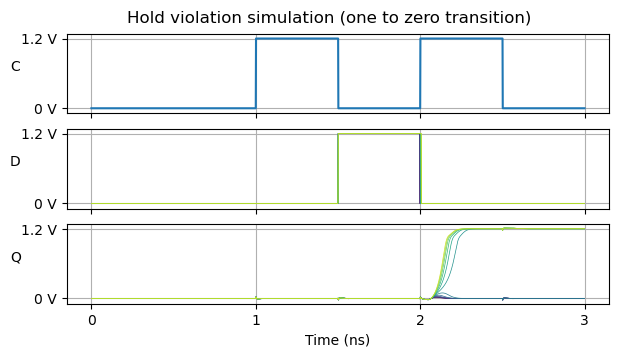

In [24]:
data = data_hold4
fig, axs = plt.subplots(3, 1, sharex=True, sharey=True)
axs[0].plot(data[0]['t']['C'] * 1e9, data[0]['x']['C'])
axs[0].set_ylabel('C', rotation=0)
axs[1].set_ylabel('D', rotation=0)
axs[2].set_ylabel('Q', rotation=0)
for n, d in enumerate(data):
    axs[1].plot(d['t']['D'] * 1e9, d['x']['D'],
                color=matplotlib.colormaps['viridis'](float(n / len(data))), linewidth=0.5)
    axs[2].plot(d['t']['Q'] * 1e9, d['x']['Q'],
                color=matplotlib.colormaps['viridis'](float(n / len(data))), linewidth=0.5)
for ax in axs:
    ax.grid()
    ax.set_yticks([0, 1.2], ['0 V', '1.2 V'])
    ax.xaxis.set_major_locator(plticker.MultipleLocator(base=1))
axs[-1].set_xlabel('Time (ns)')
plt.suptitle('Hold violation simulation (one to zero transition)', y=0.95);

In [25]:
corners = ['mos_ff_mismatch']
runs_per_corner = {'mos_ff_mismatch': 250}
holds = np.arange(5e-12, 11e-12, 1e-12)
try:
    data_hold5 = load_data('hold5.pickle')
except FileNotFoundError:
    data_hold5 = [{} for _ in range(holds.size)]
    for n, hold in enumerate(holds):
        for corner in corners:
            def sim(vdd=vdd, temperature=temperature, rising_edge=True, template=1):
                if rising_edge:
                    data0 = 0
                    data1 = vdd
                else:
                    data0 = vdd
                    data1 = 0
                template = {1: data_change_template, 2: data_change2_template}[template]
                return run_sim(template, mos_corner=corner,
                               vdd=vdd, temperature=temperature,
                               data0=data0, data1=data1,
                               data_change=hold) | {'vdd': vdd, 'rising_edge': rising_edge, 'template': template}
    
            if corner in runs_per_corner:
                for run in range(runs_per_corner[corner]):
                    for rising_edge in [True, False]:
                        for template in [1, 2]:
                            data_hold5[n][f'{corner}_{run:04}_{int(rising_edge)}_{template}'] = sim(
                                vdd=vdd_model(), temperature=temperature_model(), rising_edge=rising_edge,
                                template=template)
            else:
                for rising_edge in [True, False]:
                    for template in [1, 2]:
                        data_hold5[n][f'{corner}_{int(rising_edge)}_{template}'] = sim(rising_edge=rising_edge, template=template)
    save_data('hold5.pickle', data_hold5)

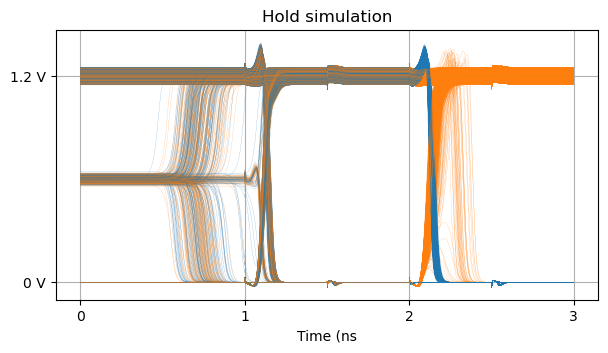

In [26]:
data = data_hold5
for d in data:
    for corner in d:
        plt.plot(d[corner]['t']['Q'] * 1e9, d[corner]['x']['Q'],
                 color='C0' if d[corner]['rising_edge'] else 'C1', linewidth=0.1)
plt.grid()
plt.yticks([0, 1.2], ['0 V', '1.2 V'])
plt.gca().xaxis.set_major_locator(plticker.MultipleLocator(base=1))
plt.xlabel('Time (ns')
plt.title('Hold simulation');

In [27]:
def meets_hold(trace):
    sel = trace['t']['Q'] >= 2e-9 + 325e-12
    if trace['rising_edge']:
        return np.all(trace['x']['Q'][sel] <= 0.3 * trace['vdd'])
    return np.all(trace['x']['Q'][sel] >= 0.7 * trace['vdd'])

violates_hold = np.array([not all(meets_hold(trace) for trace in d.values()) for d in data])
hold_time = holds[np.where(violates_hold)[0][-1] + 1]
hold_time

np.float64(8.999999999999998e-12)

In [28]:
np.where(violates_hold)[0]

array([0, 1, 2, 3])